In [1]:
#SALARY PREDICTION USING ENSEMBLE LEARNING

In [2]:
# Install widgets for interactive section
!pip install ipywidgets jupyterlab_widgets

In [3]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import ipywidgets as widgets
from IPython.display import display

In [4]:
# 3. Load Dataset from Drive
url = "https://drive.google.com/uc?export=download&id=1-NDkCe1YEFDr1gAHeGi5zQspec7qRPpt"
df = pd.read_csv(url)

print("Dataset Loaded Successfully")
df.head()

Dataset Loaded Successfully


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
# CHECK MISSING VALUES

print("Total Missing Values in Dataset:", df.isnull().sum().sum())
print("\nMissing Values Column Wise:\n")
print(df.isnull().sum())

Total Missing Values in Dataset: 0

Missing Values Column Wise:

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [6]:
# CHECK '?' VALUES

print("\nChecking '?' values in each column:\n")

for col in df.columns:
    if df[col].dtype == 'object':
        count_q = (df[col] == "?").sum()
        if count_q > 0:
            print(f"{col}: {count_q} '?' values found")


Checking '?' values in each column:

workclass: 1836 '?' values found
occupation: 1843 '?' values found
native.country: 583 '?' values found


In [7]:
# REPLACE '?' WITH NaN

df.replace("?", np.nan, inplace=True)
print("\nMissing After Replacing '?':\n")
print(df.isnull().sum())


Missing After Replacing '?':

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [26]:
# HANDLE MISSING VALUES

# Fill categorical columns with mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)


In [9]:
# FINAL CHECK

print("\nFinal Missing Values Check:\n")
print(df.isnull().sum())
print("\nTotal Remaining Missing:", df.isnull().sum().sum())


Final Missing Values Check:

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Total Remaining Missing: 0


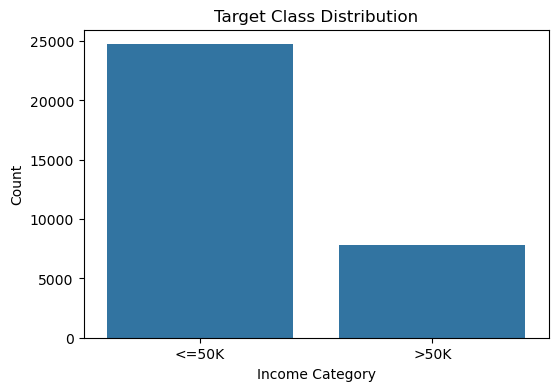

Class Distribution Percentage:

income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


In [10]:
# EDA - Target Class Distribution

plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df)
plt.title("Target Class Distribution")
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()

# Show percentage distribution
print("Class Distribution Percentage:\n")
print(df['income'].value_counts(normalize=True) * 100)

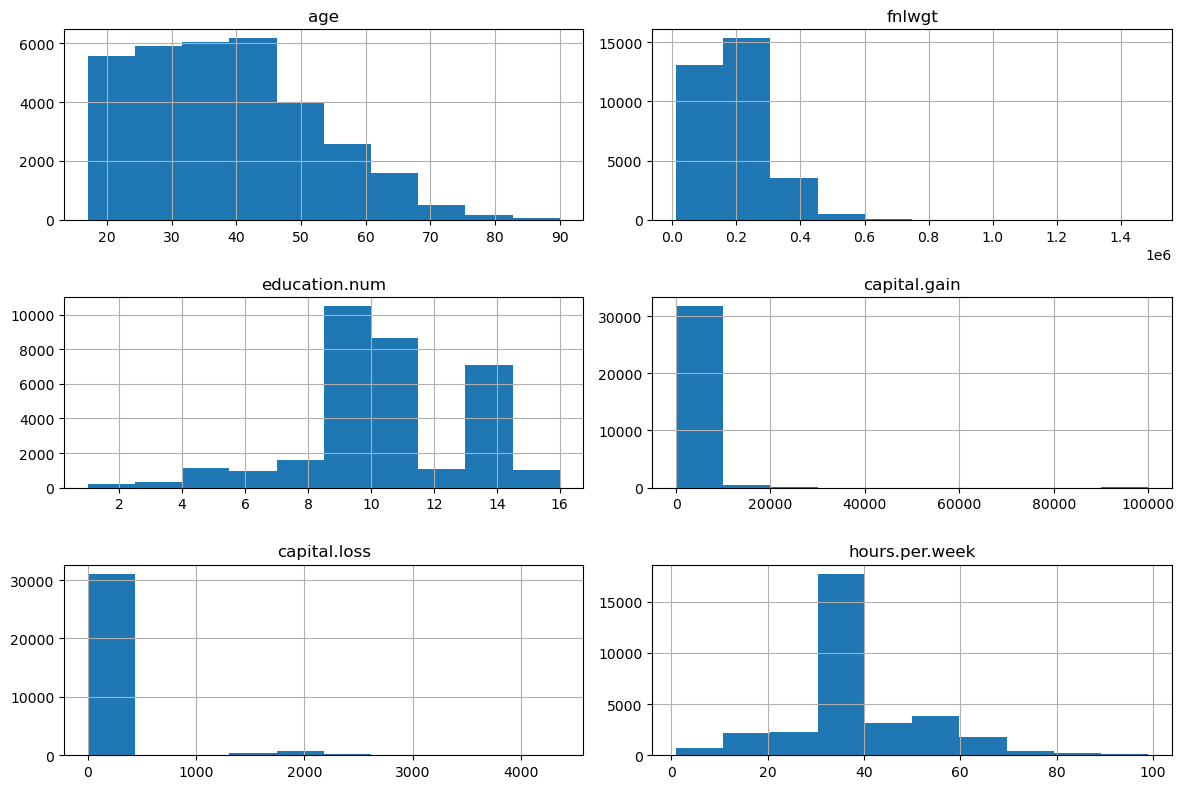

In [11]:
# EDA - Numerical Features Distribution

df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

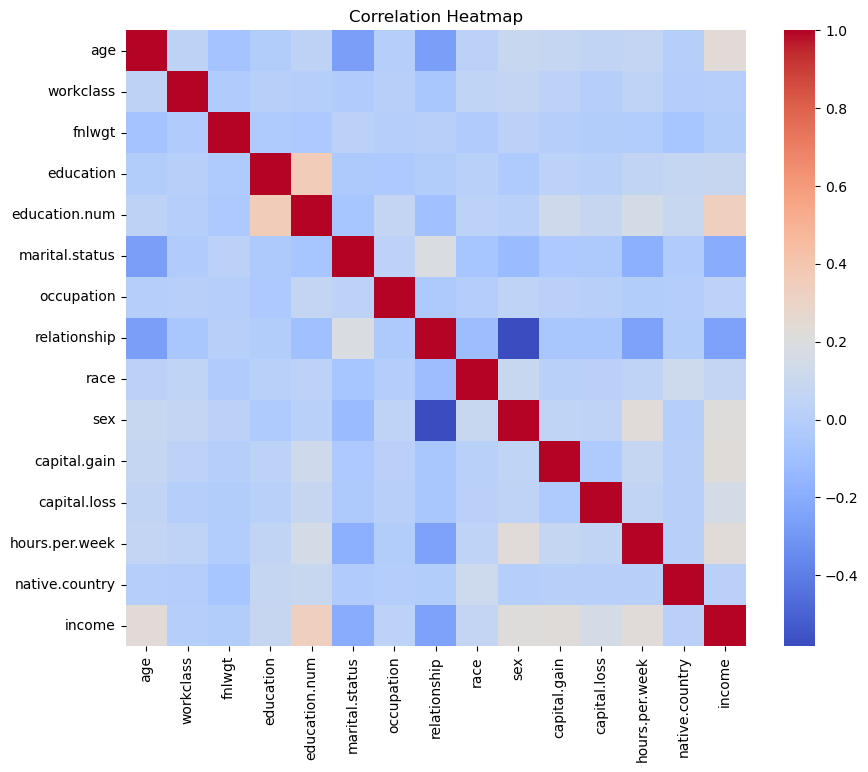

In [12]:
# EDA - Correlation Heatmap

from sklearn.preprocessing import LabelEncoder

df_temp = df.copy()

le_temp = LabelEncoder()

for col in df_temp.columns:
    if df_temp[col].dtype == 'object':
        df_temp[col] = le_temp.fit_transform(df_temp[col])

plt.figure(figsize=(10,8))
sns.heatmap(df_temp.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

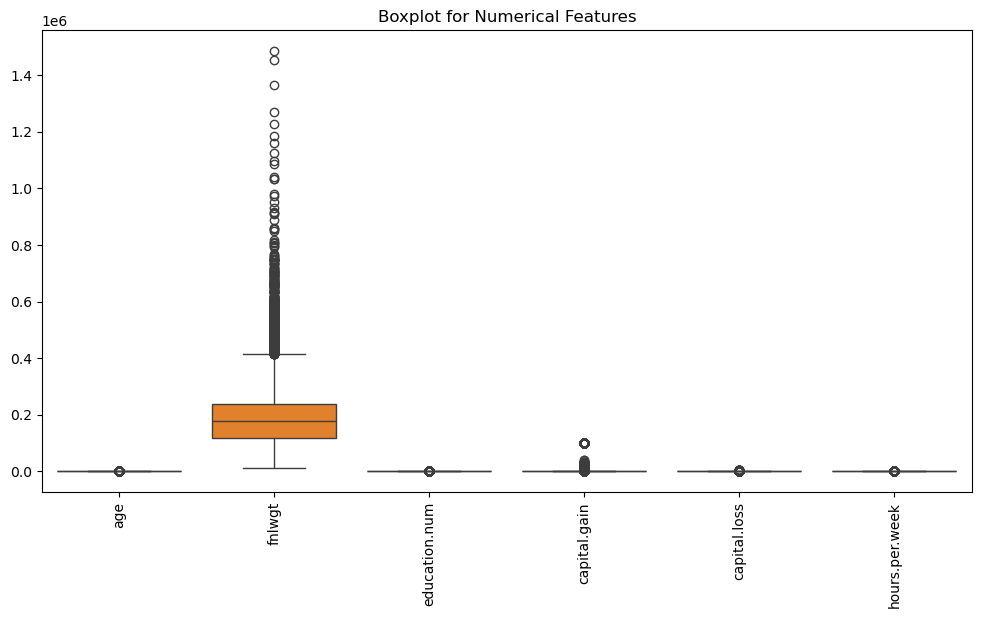

In [13]:
# EDA - Boxplots for Outlier Detection

plt.figure(figsize=(12,6))
sns.boxplot(data=df.select_dtypes(include=['int64','float64']))
plt.xticks(rotation=90)
plt.title("Boxplot for Numerical Features")
plt.show()

In [14]:
# Encode Categorical Variables
encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

In [15]:
# Train–Test Split
TEST_SIZE = 0.25
RANDOM_STATE = 42

X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\nTrain Size:", len(X_train), "Test Size:", len(X_test))


Train Size: 24420 Test Size: 8141


In [16]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 20, 'n_estimators': 200}


In [18]:
# Ensemble Model
gb = GradientBoostingClassifier()
ada = AdaBoostClassifier()

voting = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', gb),
        ('ada', ada)
    ],
    voting='hard'
)
voting.fit(X_train, y_train)

,estimators,"[('rf', ...), ('gb', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1


In [19]:
# Evaluation
y_pred = voting.predict(X_test)

print("\nTRAINING ACCURACY:", round(accuracy_score(y_train, voting.predict(X_train)), 4))
print("TEST ACCURACY    :", round(accuracy_score(y_test, y_pred), 4))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))


TRAINING ACCURACY: 0.8783
TEST ACCURACY    : 0.8573

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      6197
           1       0.78      0.56      0.65      1944

    accuracy                           0.86      8141
   macro avg       0.83      0.76      0.78      8141
weighted avg       0.85      0.86      0.85      8141

Precision: 0.7777
Recall   : 0.5633
F1 Score : 0.6533


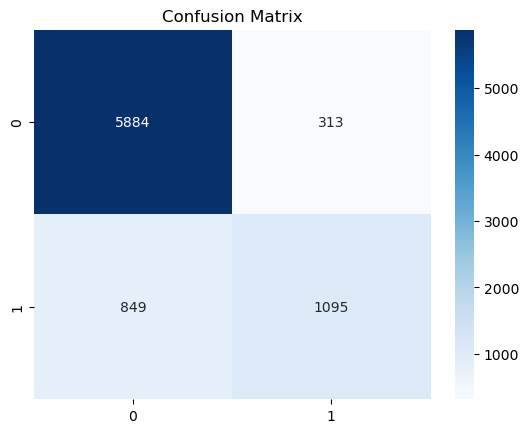

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


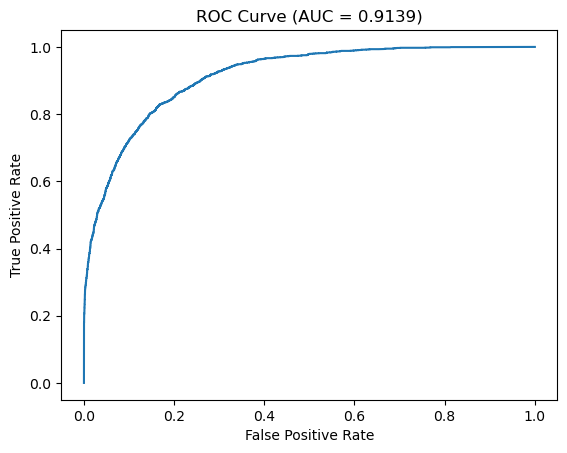

AUC Score: 0.9139


In [21]:
# ROC + AUC
y_prob = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {round(auc_score,4)})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print("AUC Score:", round(auc_score,4))

In [22]:
# Cross Validation
cv_scores = cross_val_score(best_rf, X, y, cv=5)
print("Cross Validation Score:", round(cv_scores.mean(),4))

Cross Validation Score: 0.808


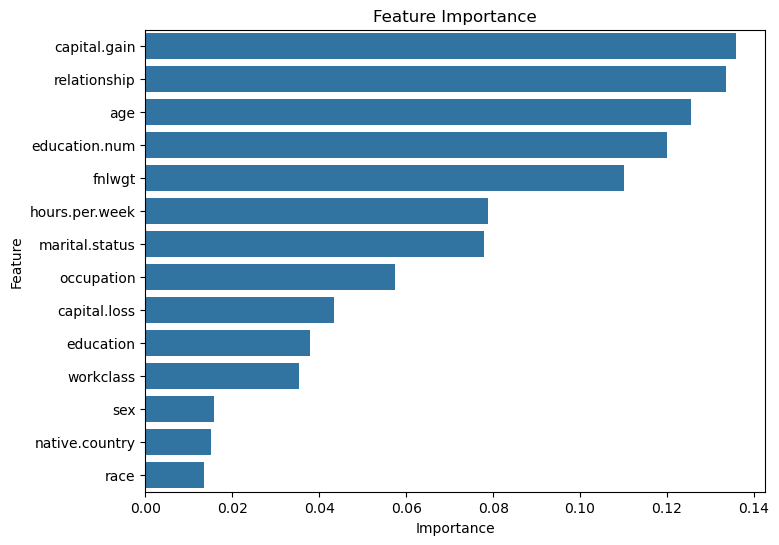

In [23]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance")
plt.show()

In [25]:
print("\n===== Salary Prediction =====")

age = widgets.IntSlider(value=30, min=18, max=65, description='Age:')
hours = widgets.IntSlider(value=40, min=1, max=80, description='Hours/Week:')
education = widgets.Dropdown(options=encoders['education'].classes_, description='Education:')
occupation = widgets.Dropdown(options=encoders['occupation'].classes_, description='Occupation:')
workclass = widgets.Dropdown(options=encoders['workclass'].classes_, description='Workclass:')
predict_button = widgets.Button(description="Predict Salary")

result_label = widgets.Label()

display(age, hours, education, occupation, workclass, predict_button, result_label)


def predict_salary(b):
    
    input_data = {
        'age': age.value,
        'hours-per-week': hours.value,
        'education': encoders['education'].transform([education.value])[0],
        'occupation': encoders['occupation'].transform([occupation.value])[0],
        'workclass': encoders['workclass'].transform([workclass.value])[0]
    }

    input_df = pd.DataFrame([input_data])

    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0

    input_df = input_df[X.columns]

    input_scaled = scaler.transform(input_df)

    prediction = voting.predict(input_scaled)

    if prediction[0] == 1:
        result_label.value = "💰 Predicted Salary: >50K"
    else:
        result_label.value = "💼 Predicted Salary: ≤50K"


predict_button.on_click(predict_salary)


===== Salary Prediction =====


IntSlider(value=30, description='Age:', max=65, min=18)

IntSlider(value=40, description='Hours/Week:', max=80, min=1)

Dropdown(description='Education:', options=('10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'A…

Dropdown(description='Occupation:', options=('Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial'…

Dropdown(description='Workclass:', options=('Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-i…

Button(description='Predict Salary', style=ButtonStyle())

Label(value='')